<a href="https://colab.research.google.com/github/Virppsa/ai-kursinis-2/blob/main/Kursinis(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, Flatten, Dense, Lambda
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()
np.random.seed(237)

In [2]:
from google.colab import drive
from keras.datasets import mnist
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Load Dataset
(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
num_labels = len(np.unique(Y_train))
num_labels

10

In [5]:
# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.reshape(-1,28,28,1)

In [6]:
#Model construction:--------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model

# Model construction:--------------------------------------------------------
img_shape = (28, 28, 1)    # for MNIST
#batch_size = 16
batch_size = 256
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

# Capture shape before flattening
shape_before_flattening = x.shape  # Use .shape instead of K.int_shape

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

# Print the captured shape
print("Shape before flattening:", shape_before_flattening)


Shape before flattening: (None, 14, 14, 64)


In [7]:
# # sampling function
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

# Sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mu + K.exp(0.5 * z_log_sigma) * epsilon  # Use 0.5 to scale log_sigma correctly

# Explicitly define the output shape
def sampling_output_shape(input_shape):
    return input_shape[0]  # The output shape is the same as z_mu's shape

# Sample vector from the latent distribution
z = Lambda(sampling, output_shape=sampling_output_shape)([z_mu, z_log_sigma])


In [8]:
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np

# Decoder takes the latent distribution sample as input
decoder_input = Input(shape=(latent_dim,))
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)

# Reverse the Conv layers from the encoder
x = Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# Decoder model
decoder = Model(decoder_input, x, name="decoder")

# Apply decoder to the sampled latent variable
z_decoded = decoder(z)


In [9]:
from tensorflow.keras.layers import Layer  # Import Layer class

class CustomVariationalLayer(Layer):  # Use the imported Layer class
    def call(self, inputs):
        x, z_decoded, z_mu, z_log_sigma = inputs
        # Flatten for reconstruction loss
        x_flat = tf.reshape(x, shape=(-1, np.prod(img_shape)))
        z_decoded_flat = tf.reshape(z_decoded, shape=(-1, np.prod(img_shape)))

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(metrics.binary_crossentropy(x_flat, z_decoded_flat), axis=-1)
        )

        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_sigma - tf.square(z_mu) - tf.exp(z_log_sigma)
        )

        # Add losses
        self.add_loss(reconstruction_loss + kl_loss)
        return x  # Pass the input forward



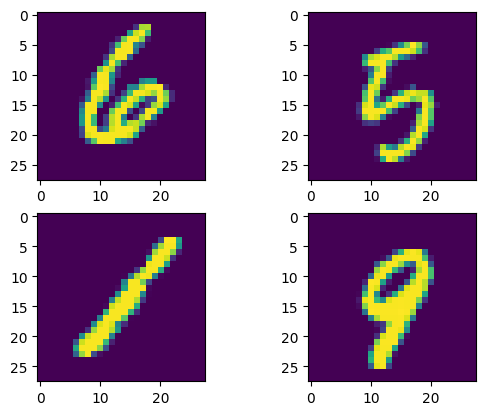

In [10]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()


In [11]:
# Apply the custom loss layer
y = CustomVariationalLayer()([input_img, z_decoded, z_mu, z_log_sigma])


In [12]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        401,440 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 2)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 28, 28, 1)      │         93,313 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer  │ (None, 28, 28, 1)      │              0 │ input_layer[0][0],     │
│ (CustomVariationalLayer)  │                        │                │ decoder[0][0],         │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 587,557 (2.24 MB)

 Trainable params: 587,557 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

#Treniravimas su dalinai data inside ir dalinai data generated



Training Generation 1...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 90.4283
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 61.1107
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 56.9709
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 55.1074
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 54.2402
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 53.5118
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 52.8056
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 52.2927
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 52.0130
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 51.6286
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 51.3610
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 51.0141
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 50.6723
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 50.4

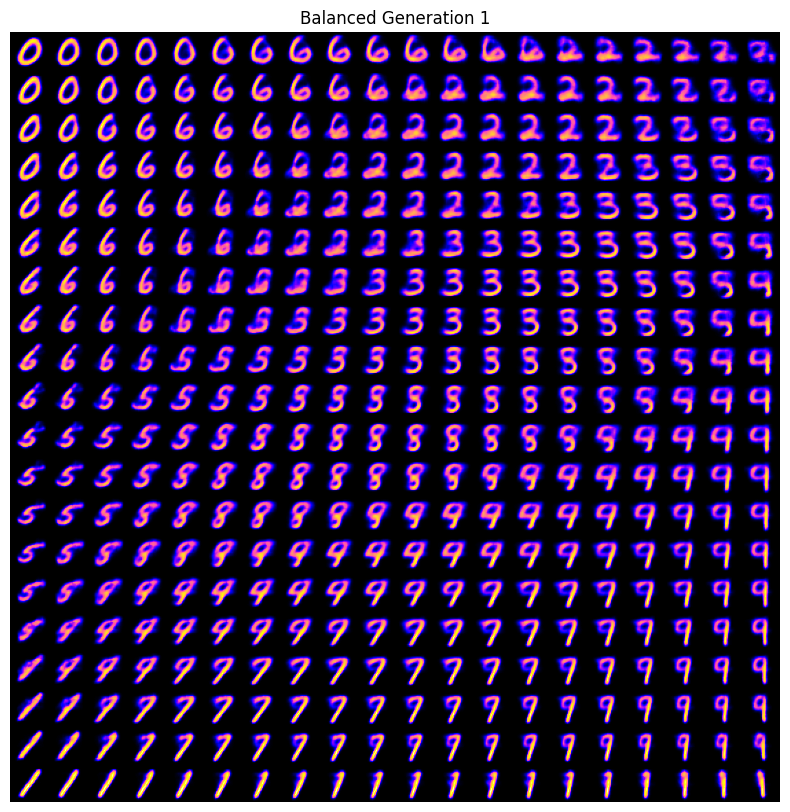

Training Generation 2...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 50.0132
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 50.0059
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 49.9621
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 49.6671
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 49.7278
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 49.8063
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 49.5331
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 49.5646
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 49.5016
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 49.5172
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 49.2538
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 49.3166
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 49.3806
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 49.11

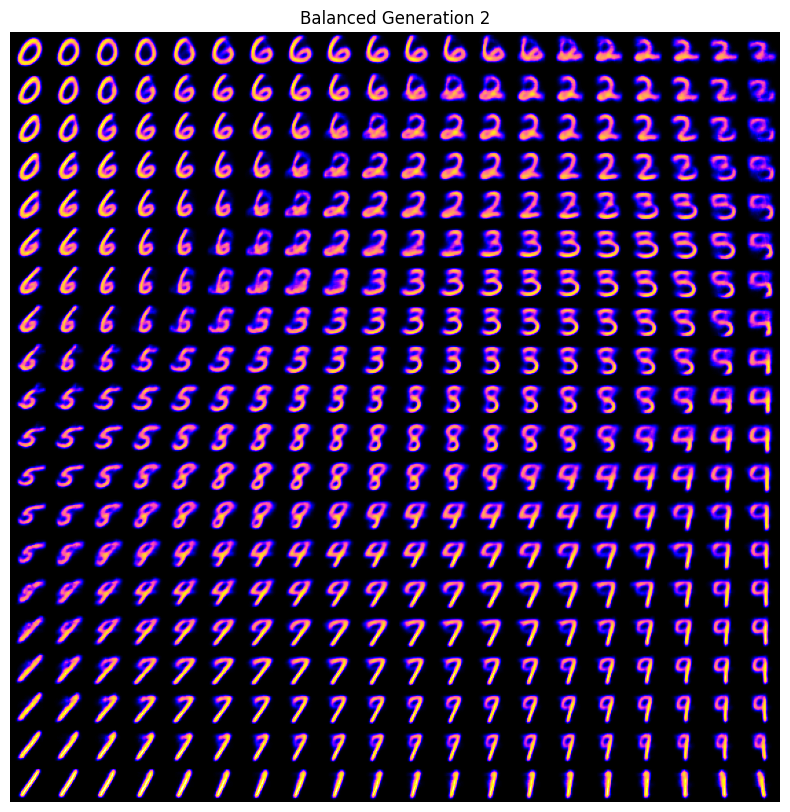

Training Generation 3...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 48.7272
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 48.6683
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 48.6103
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 48.4791
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 48.4879
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 48.4111
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 48.2916
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 48.3380
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 48.2563
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 48.2231
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 48.2729
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 48.1803
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 48.1769
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 48.1

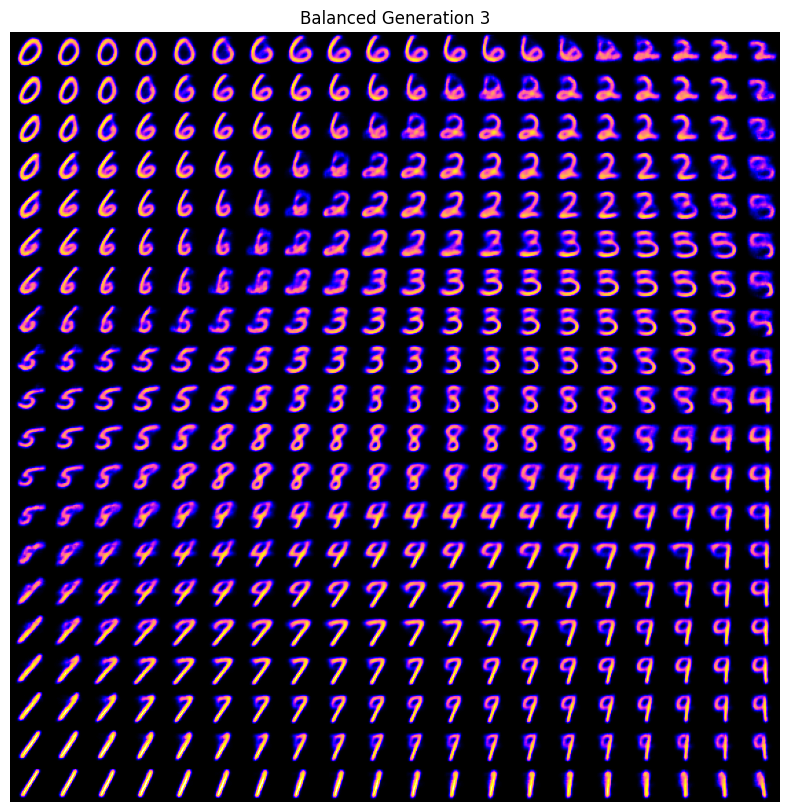

Training Generation 4...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 47.7184
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 47.7487
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.7922
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.7405
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.6147
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.5118
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.5020
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 47.4559
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 47.6074
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.4116
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 47.3729
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 47.4898
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.3875
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.3630
E

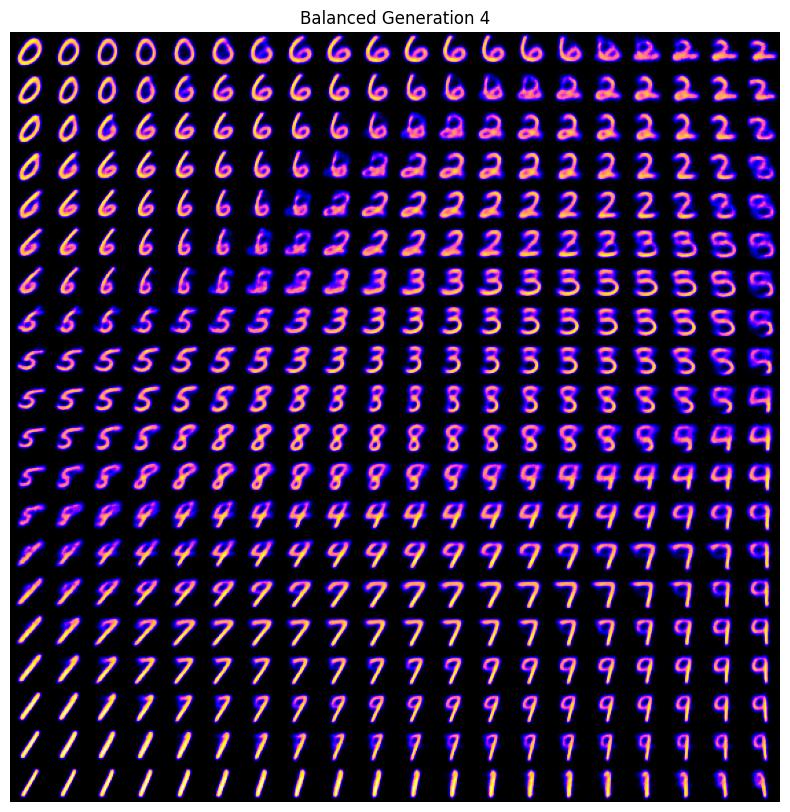

Training Generation 5...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.3614
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.3835
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.3902
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 47.2052
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.1107
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 47.1365
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.2457
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.1070
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.1043
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.0924
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.1199
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.1034
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 46.9705
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 47.

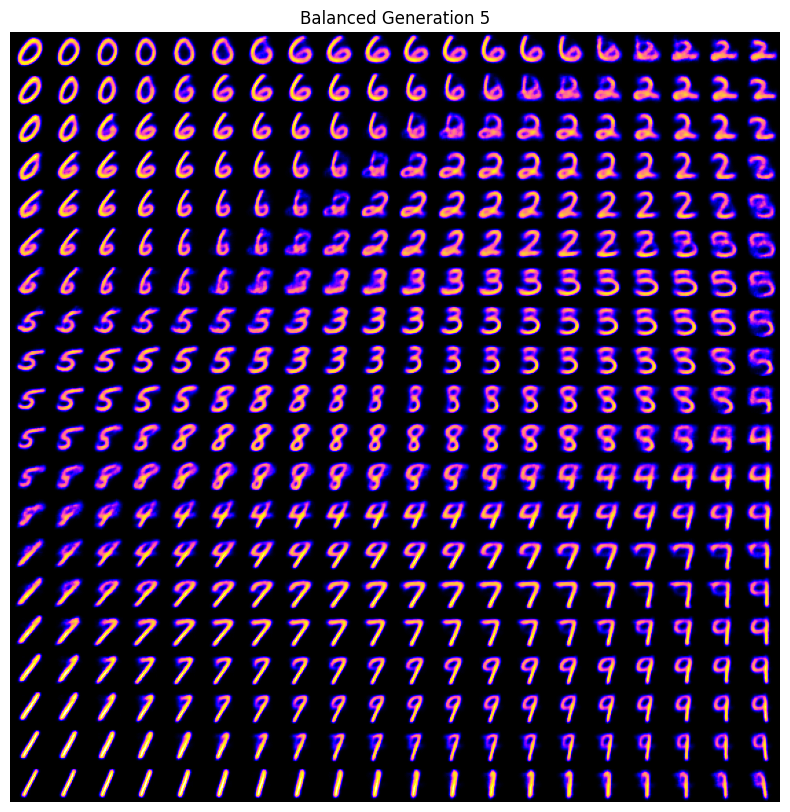

In [13]:
# Parameters
real_ratio = 0.75  # 75% real data
generated_ratio = 0.25  # 25% generated data
total_size = 60000  # Fixed total dataset size per generation
latent_dim = 2
batch_size = 256
num_epochs = 20  # Train for 20 epochs per generation
num_generations = 5  # Number of generations
digit_size = 28
n = 20  # Grid size for visualization (20x20 digits)

# Function to balance training data
def balance_training_set(real_data, generated_data, total_size, real_ratio, generated_ratio):
    n_real = int(total_size * real_ratio)
    n_generated = total_size - n_real  # Remaining for generated data

    # Sample real data
    real_indices = np.random.choice(real_data.shape[0], n_real, replace=False)
    real_subset = real_data[real_indices]

    # Sample generated data
    generated_subset = generated_data[:n_generated]

    # Combine real and generated data
    balanced_data = np.concatenate([real_subset, generated_subset], axis=0)
    np.random.shuffle(balanced_data)  # Shuffle to mix real and generated data
    return balanced_data

# Function to generate synthetic images
def generate_images(decoder, n_samples, latent_dim):
    z_samples = np.random.normal(size=(n_samples, latent_dim))  # Sample from latent space
    generated_images = decoder.predict(z_samples, batch_size=batch_size)
    return generated_images

# Start with the original dataset
X_train_balanced = X_train.copy()

# Train for multiple generations
for generation in range(num_generations):
    print(f"Training Generation {generation + 1}...")

    # Train the VAE for 20 epochs
    vae.fit(x=X_train_balanced, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size)

    # Generate synthetic images
    n_generated = int(total_size * generated_ratio)
    generated_images = generate_images(decoder, n_generated, latent_dim)

    # Balance the dataset for the next generation
    X_train_balanced = balance_training_set(X_train, generated_images, total_size, real_ratio, generated_ratio)

    # Visualize a 2D manifold of the latent space
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            Z_sample = np.array([[xi, yi]])
            Z_sample = np.tile(Z_sample, batch_size).reshape(batch_size, latent_dim)
            X_decoded = decoder.predict(Z_sample, batch_size=batch_size)
            digit = X_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.title(f"Balanced Generation {generation + 1}")
    plt.axis("off")
    plt.show()